# 推特抢跑 Notebook 验证（v0.1.1）

本 Notebook 用于验证：推文 → AI 分析 → 交易对推断 → Binance 1m K 线展示 的完整流程。

- 同时展示推文 UTC 时间与本地时间（UTC+8）。
- AI 分析结果采用多行 JSON 格式输出，便于人工检查。
- 提供 `run_analysis(page: int)` 统一入口，快速切换不同推文。

In [12]:
# 配置与依赖加载
import json,os
from datetime import datetime, timedelta
from typing import Dict, Any, Optional, List

import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Binance K 线配置
BINANCE_BASE_URL = "https://api.binance.com"
BINANCE_KLINES_PATH = "/api/v3/klines"
BINANCE_INTERVAL = "1m"
WINDOW_MINUTES = 15  # 推文时间前后各 15 分钟

# Notebook 默认页码（可在下方使用 run_analysis 覆盖）
TWEET_PAGE = 0  # 使用 latest.json 中的第几条推文（data["tweets"][page]）

TARGET_USER = "cz_binance"   # 默认抓取用户（不含@）
TWEET_LIMIT = 1              # 每次请求推文条数
REQUEST_INTERVAL_SEC = 5     # 请求间隔（固定5秒）


# Poe(OpenAI兼容)配置（如需使用 AI 分析）
AI_API_KEY = "bvJrIZp3bug_ZHHvkBTQmN_HanLRg-J6yEpRwAocESw"  # 示例 Key（建议改为环境变量）
AI_BASE_URL = "https://api.poe.com/v1"
AI_MODEL = "gpt-5.1"

# OpenAI 代理开关与配置（按需启用）
USE_OPENAI_PROXY = True  # 开关：True 使用下方代理，False 直连
OPENAI_PROXY = {
    "http": "http://localhost:1080",
    "https": "http://localhost:1080",
}

In [13]:

def read_text(path: str) -> str:
    """读取文本文件，返回内容。"""
    with open(path, "r", encoding="utf-8") as f:
        return f.read()


# -----------------------
# AI 分析（可选）
# -----------------------
def ai_analyze_text(text: str, author, introduction) -> str:
    # 允许通过函数参数或全局 USE_OPENAI_PROXY 控制是否走代理
    promot = read_text("提示词.txt")
    promot = promot.replace('{text1}', text)
    promot = promot.replace('{text2}', author)
    promot = promot.replace('{text3}', introduction)
    proxy = USE_OPENAI_PROXY
    try:
        import openai  # 延迟导入
        # 代理支持：优先使用 httpx 客户端方式；失败则回退到环境变量
        if proxy:
            try:
                from httpx import Client as _HttpxClient
                # 修正：httpx 的参数为 proxies（dict 或 str），不是 proxy
                http_client = _HttpxClient(proxies=OPENAI_PROXY, timeout=30.0)
                client = openai.OpenAI(api_key=AI_API_KEY, base_url=AI_BASE_URL, http_client=http_client)
            except Exception:
                import os as _os
                _os.environ["HTTP_PROXY"] = OPENAI_PROXY.get("http", "")
                _os.environ["HTTPS_PROXY"] = OPENAI_PROXY.get("https", "")
                client = openai.OpenAI(api_key=AI_API_KEY, base_url=AI_BASE_URL)
        else:
            client = openai.OpenAI(api_key=AI_API_KEY, base_url=AI_BASE_URL)

        chat = client.chat.completions.create(
            model=AI_MODEL,
            messages=[{"role": "user", "content": promot}],
            temperature=0.2,
            max_tokens=500,
        )
        # 兼容 openai 返回对象的两种可能结构
        content: Any = None
        if chat and getattr(chat, "choices", None):
            choice0 = chat.choices[0]
            msg = getattr(choice0, "message", None)
            if isinstance(msg, dict):
                content = msg.get("content")
            else:
                content = getattr(msg, "content", None)
        return content or "(AI 无内容返回)"
    except Exception as e:
        return f"(AI 跳过：{e})"


In [14]:
def load_single_tweet(path: str, page: int) -> Dict[str, Any]:
    """从 latest.json 中读取指定 page 的单条推文。
    - 结构遵循需求：data["tweets"][page]
    - 若顶层不是 dict，而是 list，则直接用 list[page]
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if isinstance(data, dict):
        tweets = data.get("tweets") or data
    else:
        tweets = data
    return tweets[page]


def parse_tweet_time(tweet: Dict[str, Any]) -> datetime:
    """将推文中的 createdAt 转为 UTC datetime 对象。
    示例格式："Thu Nov 13 16:25:19 +0000 2025"
    """
    created_at = tweet.get("createdAt") or tweet.get("created_at")
    return datetime.strptime(created_at, "%a %b %d %H:%M:%S %z %Y")


def to_local_time(dt_utc: datetime, offset_hours: int = 8) -> datetime:
    """将 UTC 时间转换为本地时间（默认 UTC+8）。"""
    return dt_utc + timedelta(hours=offset_hours)

In [15]:
def call_ai_for_tweet(text: str, author, introduction) -> Dict[str, Any]:
    """调用已有 ai_analyze_text，对推文文本做分析并尽量解析为 JSON dict。
    - use_proxy 为 None 时，沿用全局 USE_OPENAI_PROXY 行为
    - 若 AI 返回非严格 JSON，则包装为 {"raw": 原始字符串}
    """
    raw = ai_analyze_text(text, author, introduction)
    if not raw:
        return {"raw": "(空响应)"}
    try:
        return json.loads(raw)
    except Exception:
        return {"raw": raw}


def pretty_print_ai(ai_res: Dict[str, Any]) -> None:
    """人类友好的多行打印 AI 分析结果。"""
    if "raw" in ai_res and len(ai_res) == 1:
        print("[AI RAW]")
        print(ai_res["raw"])
        return
    try:
        print("[AI JSON]")
        print(json.dumps(ai_res, ensure_ascii=False, indent=2))
    except Exception:
        print("[AI RAW/FALLBACK]")
        print(ai_res)

In [16]:
SYMBOL_MAP = {
    "BTC": "BTCUSDT",
    "ETH": "ETHUSDT",
    "BNB": "BNBUSDT",
    "SOL": "SOLUSDT",
    "DOGE": "DOGEUSDT",
}


def normalize_symbol_from_ai(ai_res: Dict[str, Any]) -> Optional[str]:
    """从 AI 结果中提取交易币种并映射为 Binance 现货 symbol。"""
    raw_symbol = ai_res.get("交易币种")
    print(raw_symbol)
    if isinstance(raw_symbol, list) and raw_symbol:
        first = str(raw_symbol[0]).upper()
    elif isinstance(raw_symbol, str) and raw_symbol.strip():
        first = raw_symbol.strip().upper()
    else:
        return None
    base = first.replace("USDT", "").replace("/", "").upper()
    return base + "USDT"


def fallback_symbol_from_text(text: str) -> Optional[str]:
    """在 AI 无法给出交易币种时，从原始文本粗略匹配常见币种。"""
    upper = text.upper()
    for base, symbol in SYMBOL_MAP.items():
        if base in upper:
            return symbol
    return None


def detect_trade_symbol(ai_res: Dict[str, Any], text: str) -> Optional[str]:
    """综合 AI 输出与原始文本，推断最终可交易 symbol。
    - 优先 AI 输出
    - 其次文本关键词
    - 若仍无法确定，返回 None（视为不可交易）
    """
    symbol = normalize_symbol_from_ai(ai_res)
    return symbol


In [17]:
def fetch_binance_klines(symbol: str, center_time_utc: datetime,
                         minutes: int = WINDOW_MINUTES) -> List[List[Any]]:
    """获取 symbol 在 center_time 前后指定分钟窗口内的 1m K 线原始数据（使用 UTC 时间戳）。"""
    start = center_time_utc - timedelta(minutes=minutes)
    end = center_time_utc + timedelta(minutes=minutes)
    params = {
        "symbol": symbol.upper(),
        "interval": BINANCE_INTERVAL,
        "startTime": int(start.timestamp() * 1000),
        "endTime": int(end.timestamp() * 1000),
    }
    url = BINANCE_BASE_URL + BINANCE_KLINES_PATH
    resp = requests.get(url, params=params, timeout=10)
    resp.raise_for_status()
    return resp.json()


def format_klines(klines: List[List[Any]]):
    """将 Binance 原始 K 线转换为 (times, opens, highs, lows, closes)。
    times 使用本地时间（便于与本地 UTC+8 对齐）。
    """
    times, opens, highs, lows, closes = [], [], [], [], []
    for k in klines:
        ts = datetime.fromtimestamp(k[0] / 1000)
        times.append(ts)
        opens.append(float(k[1]))
        highs.append(float(k[2]))
        lows.append(float(k[3]))
        closes.append(float(k[4]))
    return times, opens, highs, lows, closes

In [18]:
def plot_candles(times, opens, highs, lows, closes,
                 tweet_time_local: datetime,
                 title: str = "",
                 tweet_time_utc: Optional[datetime] = None) -> None:
    """简单绘制 1m K 线并标出推文时间竖线。
    - X 轴：本地时间（通常为 UTC+8）
    - 图下方附加推文 UTC / 本地时间说明
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    for t, o, h, l, c in zip(times, opens, highs, lows, closes):
        color = "red" if c >= o else "green"
        ax.plot([t, t], [l, h], color=color, linewidth=1)
        ax.plot([t, t], [o, c], color=color, linewidth=4)

    ax.axvline(tweet_time_local, color="blue",
               linestyle="--", label="Tweet Time")

    if times:
        min_t, max_t = min(times), max(times)
        ax.set_xlim(min_t, max_t)

    ax.set_title(title)
    ax.set_xlabel("Time (Local, UTC+8)")
    ax.set_ylabel("Price")

    locator = mdates.AutoDateLocator()
    formatter = mdates.DateFormatter("%m-%d %H:%M")
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.legend()

    if tweet_time_utc is not None:
        info = (
            f"Tweet UTC: {tweet_time_utc.strftime('%Y-%m-%d %H:%M:%S %z')}\n" 
            f"Tweet Local (UTC+8): {tweet_time_local.strftime('%Y-%m-%d %H:%M:%S')}"
        )
        plt.figtext(0.01, -0.02, info, ha="left", va="top", fontsize=8)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [19]:
def run_analysis(page: int, json_path=None, author=None, introduction=None) -> None:
    """统一入口：分析 data["tweets"][page] 的完整链路。"""
    global TWEET_PAGE
    TWEET_PAGE = page
    print(f"[RUN] 分析 data['tweets'][{page}]")
    if not json_path:
        tweet = load_single_tweet(LOCAL_JSON_PATH, TWEET_PAGE)
    else:
        tweet = load_single_tweet(json_path, page)
    tweet_text = tweet.get("text") or tweet.get("full_text") or ""
    tweet_time_utc = parse_tweet_time(tweet)
    tweet_time_local = to_local_time(tweet_time_utc, 8)

    print("[TWEET ID   ]", tweet.get("id"))
    print("[CREATED UTC]", tweet.get("createdAt"))
    print("[CREATED CN ]", tweet_time_local.strftime("%Y-%m-%d %H:%M:%S (UTC+8)"))
    print("[TEXT       ]", tweet_text)
    
    ai_result = call_ai_for_tweet(tweet_text, author, introduction)
    pretty_print_ai(ai_result)

    base_symbol = detect_trade_symbol(ai_result, tweet_text)
    symbol = base_symbol

    direction = ai_result.get("交易方向") or ai_result.get("direction")
    confidence = ai_result.get("消息置信度") or ai_result.get("confidence")

    print("[BASE SYMBOL]", base_symbol)
    print("[SYMBOL     ]", symbol)
    print("[DIRECTION  ]", direction)
    print("[CONF       ]", confidence)

    if symbol is None:
        print("[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。")
    else:
        print(f"[INFO] 获取 {symbol} 在推文时间前后 {WINDOW_MINUTES} 分钟的 1m K 线…")
        try:
            raw_klines = fetch_binance_klines(symbol, tweet_time_utc)
            if not raw_klines:
                print("[WARN] 返回 K 线为空")
            else:
                t, o, h, l, c = format_klines(raw_klines)
                title = (
                    f"{symbol} 1m K 线（本地时间，含推文时间 "
                    f"{tweet_time_local.strftime('%Y-%m-%d %H:%M')}）"
                )
                plot_candles(
                    t, o, h, l, c,
                    tweet_time_local,
                    title=title,
                    tweet_time_utc=tweet_time_utc,
                )
        except Exception as e:
            print("[ERR] 获取或绘制 K 线失败:", e)

    summary = {
        "tweet_id": tweet.get("id"),
        "created_at_utc": tweet.get("createdAt"),
        "created_at_local": tweet_time_local.isoformat(),
        "symbol": symbol,
        "direction": direction,
        "confidence": confidence,
    }
    print("[SUMMARY]", summary)

[RUN] 分析 data['tweets'][0]
[TWEET ID   ] 1984992347395141987
[CREATED UTC] Sun Nov 02 14:33:49 +0000 2025
[CREATED CN ] 2025-11-02 22:33:49 (UTC+8)
[TEXT       ] Full disclosure. I just bought some Aster today, using my own money, on @Binance.

I am not a trader. I buy and hold. https://t.co/wvmBwaXbKD
[AI JSON]
{
  "分析结果": "特定币种利好",
  "交易币种": [
    "ASTR/USDT"
  ],
  "交易方向": "long",
  "是否基于图片": "否",
  "分析依据": "推文发布者为 cz_binance（币安创始人），属于行业顶级高影响力人物。其在推文中明确披露：自己用真金白银在币安买入“Aster”，并强调自己是买入并长期持有的风格。这属于典型的高影响力 KOL 对单一项目/代币的主动买入表态，是明显的情绪喊单利好。根据语境和币安当前上市项目，推断其指向的标的是 Astar Network，对应交易对为 ASTR/USDT。虽然他强调“不是交易员、是买入持有”，但对短线情绪同样构成利好，容易引发跟随买盘，尤其是在币安平台有现成交易对的情况下。因此该消息对 ASTR 短期价格偏利好，策略上可考虑偏短线的轻仓 long，利用情绪溢价，注意追高风险。这一判断主要基于情绪驱动的 KOL 喊单，而非链上或基本面的硬事件。",
  "预计涨跌幅": "5%-15%",
  "预期消息对市场行情影响的持续时间": "数小时至1天",
  "影响力强度": 90,
  "消息利好利空强度": 70,
  "消息置信度": 85,
  "消息中文翻译": "完全披露：我今天刚在币安自己用钱买了一些 Aster。我不是交易员，我是买入并长期持有。"
}
['ASTR/USDT']
[BASE SYMBOL] ASTRUSDT
[SYMBOL     ] ASTRUSDT
[DIRECTION  ] long
[CONF       ]

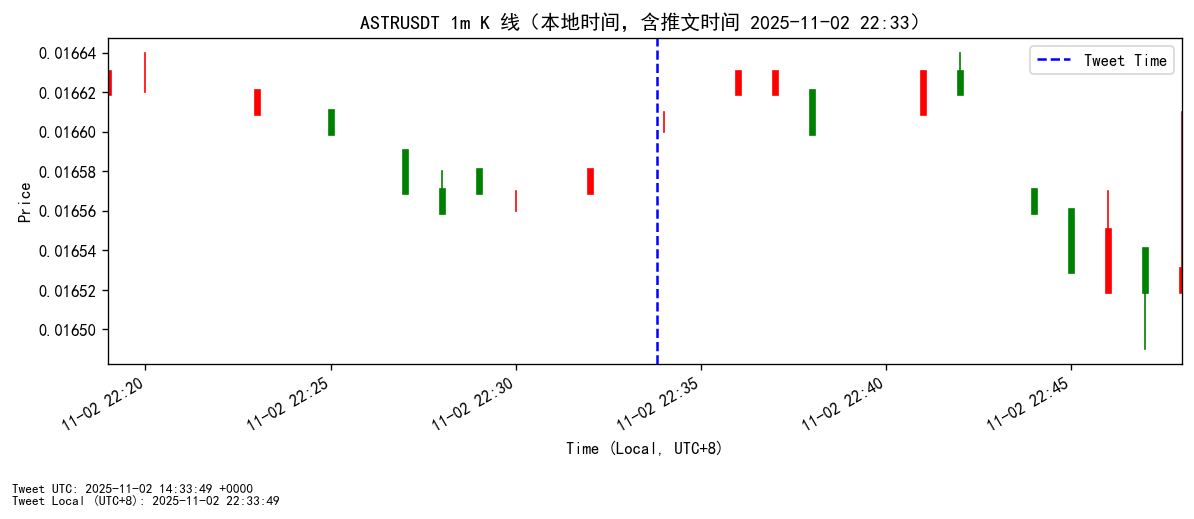

[SUMMARY] {'tweet_id': '1984992347395141987', 'created_at_utc': 'Sun Nov 02 14:33:49 +0000 2025', 'created_at_local': '2025-11-02T22:33:49+00:00', 'symbol': 'ASTRUSDT', 'direction': 'long', 'confidence': 85}


In [20]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(0, "./twitter_media/1984992347395141987.json", 'cz_binance', 'BINANCE的创始人')

In [22]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(0, "./twitter_media/1987990314997739625.json", 'haydenzadams', '发明了Uniswap协议，创始人')

[RUN] 分析 data['tweets'][0]
[TWEET ID   ] 1987990314997739625
[CREATED UTC] Mon Nov 10 21:06:40 +0000 2025
[CREATED CN ] 2025-11-11 05:06:40 (UTC+8)
[TEXT       ] Today, I’m incredibly excited to make my first proposal to Uniswap governance on behalf of @Uniswap alongside @devinawalsh and @nkennethk 

This proposal turns on protocol fees and aligns incentives across the Uniswap ecosystem

Uniswap has been my passion and singular focus for the past 8 years. What started as a small side project is now global financial infrastructure powering thousands of applications with ~$1.8 trillion in annual trading

UNI launched in 2020, but for the past 5 years Labs has been unable to meaningfully participate in Uniswap governance, and has been greatly restricted in the ways it can build value for the Uniswap community. That ends today!

This restriction was in great part due to a hostile regulatory environment that cost thousands of hours and tens of millions in legal fees. Fortunately, the regula